In [32]:
import sys
sys.path.append("../utils")
from utils import load_data, load_cgc_data, set_random_seed
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Import Keras for implementing autoencoders
import keras
from keras.models import Sequential
from keras.layers import Input, Dense
from pathlib import Path
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from vae import create_ae_model

In [33]:
set_random_seed(42)

# Can be used with both CGC and non CGC column selection 
Be careful with the comments

In [34]:
train_data, test_data, train_target = load_data(raw = False, categorical=False)
#train_data, test_data, train_target = load_cgc_data()

In [35]:
nb_cell_lines = train_data.shape[0]
print("Number of cell lines: ", nb_cell_lines)

Number of cell lines:  742


In [36]:
# Split the data 
X_train, X_test, y_train, y_test = train_test_split(train_data, train_target, test_size=0.2, random_state=42)

In [37]:
# Parameters
input_dim = X_train.shape[1]
latent_dim = 50  # Adjust the latent dimension as needed
batch_size = 32
epochs = 20

In [38]:
ae_mse_encoded_list = []
ae_spearman_encoded_list = []

best_encoder = None
best_spearman = 0

for i in range(10):
    # Create and fit the autoencoder
    set_random_seed(42+i)
    autoencoder = create_ae_model(input_dim=input_dim, latent_dim=latent_dim)
    autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, shuffle=False, validation_data=(X_test, X_test), verbose=0)

    # Use encoder part of the autoencoder for feature extraction
    encoder = keras.Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)
    encoded_features_train = encoder.predict(X_train)
    encoded_features_test = encoder.predict(X_test)

    # Fit a linear regression model using the encoded features
    encoded_model = LinearRegression()
    encoded_model.fit(encoded_features_train, y_train)

    # Make predictions on the test set
    y_pred_encoded = encoded_model.predict(encoded_features_test)

    # Calculate regression metrics
    mse_encoded = mean_squared_error(y_test, y_pred_encoded)
    r2_encoded = r2_score(y_test, y_pred_encoded)

    # Calculate Spearman's rank correlation
    spearman_encoded, p_value_encoded = spearmanr(y_test, y_pred_encoded)

    ae_mse_encoded_list.append(mse_encoded)
    ae_spearman_encoded_list.append(spearman_encoded)
    
    print(f" Run {i+1} - MSE: {mse_encoded:.4f}, R2: {r2_encoded:.4f}, Spearman: {spearman_encoded:.4f}")

    if spearman_encoded > best_spearman:
        best_spearman = spearman_encoded
        best_encoder = encoder


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
 Run 1 - MSE: 0.0060, R2: 0.1970, Spearman: 0.4266
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
 Run 2 - MSE: 0.0057, R2: 0.2439, Spearman: 0.4474
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
 Run 3 - MSE: 0.0054, R2: 0.2757, Spearman: 0.4903
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
 Run 4 - MSE: 0.0057, R2: 0.2433, Spearman: 0.4411
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
 Run 5 - MSE: 0.0056, R2: 0.2575, Spearman: 0.4336
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
 Run 6 - MSE: 0.0059, R2: 0.2183, Spearman: 0.4058
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
 Run 7 - MSE: 0.0057, R2: 0.2441, Spearman: 0.4314
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
 Run 8 - MSE: 0.0059, R2: 0

In [39]:
figures_dir = Path("../../results/figures")
figures_dir.mkdir(parents = True,exist_ok=True)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


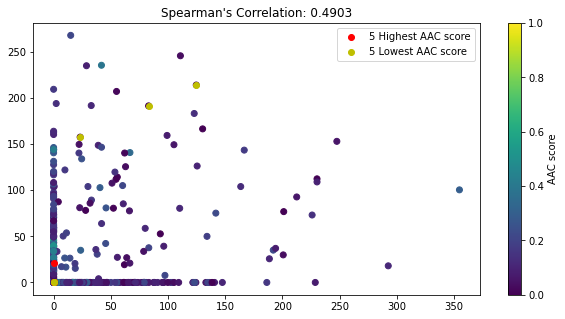

In [48]:
sorted_indices = np.argsort(y_train['AAC'].values)
# Get the 5 highest and lowest values
highest_indices = sorted_indices[-5:]
lowest_indices = sorted_indices[:5]
latent_x = 0
latent_y = 1
encoded_features_train = best_encoder.predict(X_train)
# Plot the best latent features
plt.figure(figsize=(8, 6))
plt.scatter(encoded_features_train[:, 0], encoded_features_train[:, 1], c=y_train['AAC'], cmap='viridis')
plt.scatter(encoded_features_train[highest_indices, 0], encoded_features_train[highest_indices, 1], c='r', label='5 Highest AAC score')
plt.scatter(encoded_features_train[lowest_indices, 0], encoded_features_train[lowest_indices, 1], c='y', label='5 Lowest AAC score')
plt.colorbar(label='AAC score')
plt.legend()
plt.title(f"Spearman's Correlation: {best_spearman:.4f}")
plt.tight_layout()
plt.savefig(figures_dir / "best_ae_latent_features.png")
plt.show()

In [41]:
# Add the project root directory to the Python path
project_root = Path().resolve().parent.parent
sys.path.append(str(project_root))
# Load the data
data_path = project_root / 'data' / 'encoded'
total_data = pd.concat([train_data, test_data])
encoded_features = best_encoder.predict(total_data)
print(encoded_features.shape)
encoded_features = pd.DataFrame(encoded_features, columns=["encoded_feature_" + str(i) for i in range(encoded_features.shape[1])])
encoded_features.to_csv(data_path / 'ae_data.csv', index=False)
#encoded_features.to_csv(data_path / 'ae_cgc_data.csv', index=False)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(1046, 50)


# VAE

In [42]:
from src.utils.vae import VAE, train
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [43]:
# Use VAE for feature selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_random_seed(42)
batch_size = 32
epochs = 10
input_dim = X_train.shape[1]
latent_dim = 50
# Convert to tensor
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [44]:
vae_mse_encoded_list = []
vae_spearman_encoded_list = []

best_vae_encoder = None
best_vae_spearman = 0

for i in range(10):
    set_random_seed(42+i)
    model = VAE(input_dim=input_dim, latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    train(model, train_loader, test_loader, optimizer, epochs=epochs, device=device)

    # Extract latent features from X_train
    latent_train, _ = model.encode(X_train_tensor)
    latent_test, _ = model.encode(X_test_tensor)
    latent_train = latent_train.detach().numpy()
    latent_test = latent_test.detach().numpy()
    print(latent_train.shape) 

    # Train a linear regression model on the encoded features
    vae_encoded_model = LinearRegression()
    vae_encoded_model.fit(latent_train, y_train)
    y_pred_vae = vae_encoded_model.predict(latent_test)

    # Calculate regression metrics
    mse_vae = mean_squared_error(y_test, y_pred_vae)
    r2_vae = r2_score(y_test, y_pred_vae)
    spearman_vae, p_value_vae = spearmanr(y_test, y_pred_vae)

    vae_mse_encoded_list.append(mse_vae)
    vae_spearman_encoded_list.append(spearman_vae)

    print(f" Run {i+1} - MSE: {mse_vae:.4f}, R2: {r2_vae:.4f}, Spearman: {spearman_vae:.4f}")

    if spearman_vae > best_vae_spearman:
        best_vae_spearman = spearman_vae
        best_vae_encoder = model

Epoch 1/10, Train Loss: 2.8126, Val Loss: 1.4843
Epoch 2/10, Train Loss: 1.1228, Val Loss: 0.4078
Epoch 3/10, Train Loss: 0.3896, Val Loss: 0.2231
Epoch 4/10, Train Loss: 0.2025, Val Loss: 0.1411
Epoch 5/10, Train Loss: 0.1262, Val Loss: 0.1102
Epoch 6/10, Train Loss: 0.0927, Val Loss: 0.0966
Epoch 7/10, Train Loss: 0.0785, Val Loss: 0.0890
Epoch 8/10, Train Loss: 0.0689, Val Loss: 0.0809
Epoch 9/10, Train Loss: 0.0641, Val Loss: 0.0785
Epoch 10/10, Train Loss: 0.0592, Val Loss: 0.0732
(593, 50)
 Run 1 - MSE: 0.0079, R2: -0.0564, Spearman: 0.2376
Epoch 1/10, Train Loss: 2.5899, Val Loss: 1.3079
Epoch 2/10, Train Loss: 1.0297, Val Loss: 0.4303
Epoch 3/10, Train Loss: 0.3556, Val Loss: 0.2113
Epoch 4/10, Train Loss: 0.1747, Val Loss: 0.1354
Epoch 5/10, Train Loss: 0.1124, Val Loss: 0.1074
Epoch 6/10, Train Loss: 0.0855, Val Loss: 0.0930
Epoch 7/10, Train Loss: 0.0709, Val Loss: 0.0842
Epoch 8/10, Train Loss: 0.0622, Val Loss: 0.0781
Epoch 9/10, Train Loss: 0.0567, Val Loss: 0.0739
Epoch 

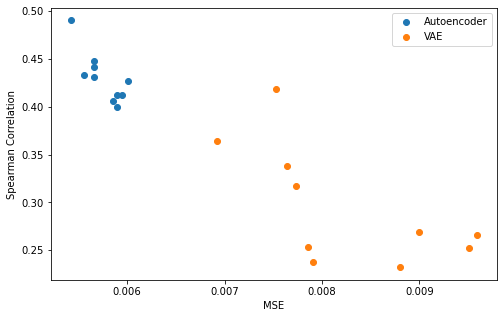

In [45]:
plt.figure(figsize=(6, 5))
plt.scatter(ae_mse_encoded_list, ae_spearman_encoded_list, label='Autoencoder')
plt.scatter(vae_mse_encoded_list, vae_spearman_encoded_list, label='VAE')
plt.xlabel('MSE')
plt.ylabel('Spearman Correlation')
plt.legend()
plt.tight_layout()
plt.savefig(figures_dir / "ae_vae_spearman.png")
plt.show()

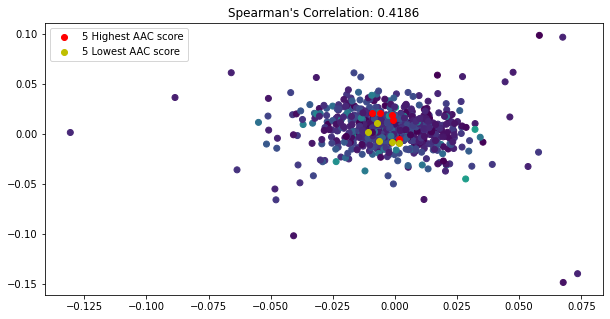

In [46]:
latent_train, _ = best_vae_encoder.encode(X_train_tensor)
latent_train = latent_train.detach().numpy()

# PLot the 5 values with the highest and lowest values of AAC
# Sort the predictions
sorted_indices = np.argsort(y_train['AAC'].values)
# Get the 5 highest and lowest values
highest_indices = sorted_indices[-5:]
lowest_indices = sorted_indices[:5]
latent_x = 0
latent_y = 1
# Plot the values in latent space
plt.figure(figsize=(8, 5))
plt.scatter(latent_train[:, latent_x], latent_train[:, latent_y], c=y_train['AAC'], cmap='viridis')
plt.scatter(latent_train[highest_indices, latent_x], latent_train[highest_indices, latent_y], c='r', label='5 Highest AAC score')
plt.scatter(latent_train[lowest_indices, latent_x], latent_train[lowest_indices, latent_y], c='y', label='5 Lowest AAC score')
plt.title(f"Spearman's Correlation: {best_vae_spearman:.4f}")
plt.legend()
plt.tight_layout()
plt.savefig(figures_dir / "best_vae_latent_features.png")
plt.show()


In [47]:
total_data = pd.concat([train_data, test_data])
total_data_tensor = torch.tensor(total_data.values, dtype=torch.float32)
encoded_features,_ = model.encode(total_data_tensor)
project_root = Path().resolve().parent.parent
sys.path.append(str(project_root))
# Load the data
data_path = project_root / 'data' / 'encoded'
encoded_features = pd.DataFrame(encoded_features.detach().numpy(), columns=["encoded_feature_" + str(i) for i in range(encoded_features.shape[1])])
encoded_features.to_csv(data_path / 'vae_data.csv', index=False)
#encoded_features.to_csv(data_path / 'vae_cgc_data.csv', index=False)